# Agent-based Transportation Model

In [3]:
import logging
import ssl; ssl._create_default_https_context = ssl._create_stdlib_context

from astropy import units
from pyrosm.data import sources
import ipywidgets as widgets
from IPython.display import display

from dpd.modeling import (
    TransportationModel,
    OriginDestinationDataFrame,
    Zones,
    ABTMMap,
)
from dpd.osm import OSMMap
from dpd.osrm import OSRM

logging.basicConfig(level=logging.INFO)

In [4]:
# Issues
# 1. Turns yield to oncoming traffic - compute the angles of lanes that approach intersections. if they are within say 15 degrees, no turn, if not, we need to add a yeild to the intersection logic.
#    a. we could get turns from osrm... then the route contains them and we know before we approach the intersection?
# 2. Map generation
#    b. Driveways - just need a way to generate these from routes - where do people start and stop.
#    d. get priority lanes from osm for stop signs
#    e. higher quality signal plan generation
# 3. Better physics - e.g. acceleration, deceleration
# 4. Fix stop intersection and signal intersection
# 5. Add cyclist and pedestrian

In [3]:
from itertools import combinations

from shapely.geometry import Point, LineString

from dpd.mapping import Map, Intersection, Road

def test_map():
    map_ = Map()
    for x in range(2):
        for y in range(2):
            map_.add_intersection(Intersection(str([x, y]), Point(x, y)))
    for input_intersection, output_intersection in combinations(
        map_.intersections["Intersection"], 2
    ):
        name = input_intersection.name + " to " + output_intersection.name
        geometry = LineString(
            [input_intersection.geometry, output_intersection.geometry]
        )
        map_.add_road(Road(name, geometry, input_intersection, output_intersection, 1))
        map_.roads["Road"][name].max_speed = 1 * units.meter / units.second
    return  map_


map_ = test_map()
#map_.plot(include_intersections=True)

INFO:root:Simulating round 0
INFO:root:dd92d7e5-ccf9-488f-940c-100137481081 freeflow traffic, no one ahead
INFO:root:906f8ea6-272b-4619-afbe-43b9f86e6790 reached end of lane, pass control to intersection
INFO:root:Simulating round 1
INFO:root:906f8ea6-272b-4619-afbe-43b9f86e6790 freeflow traffic, no one ahead
INFO:root:dd92d7e5-ccf9-488f-940c-100137481081 reached end of lane, pass control to intersection


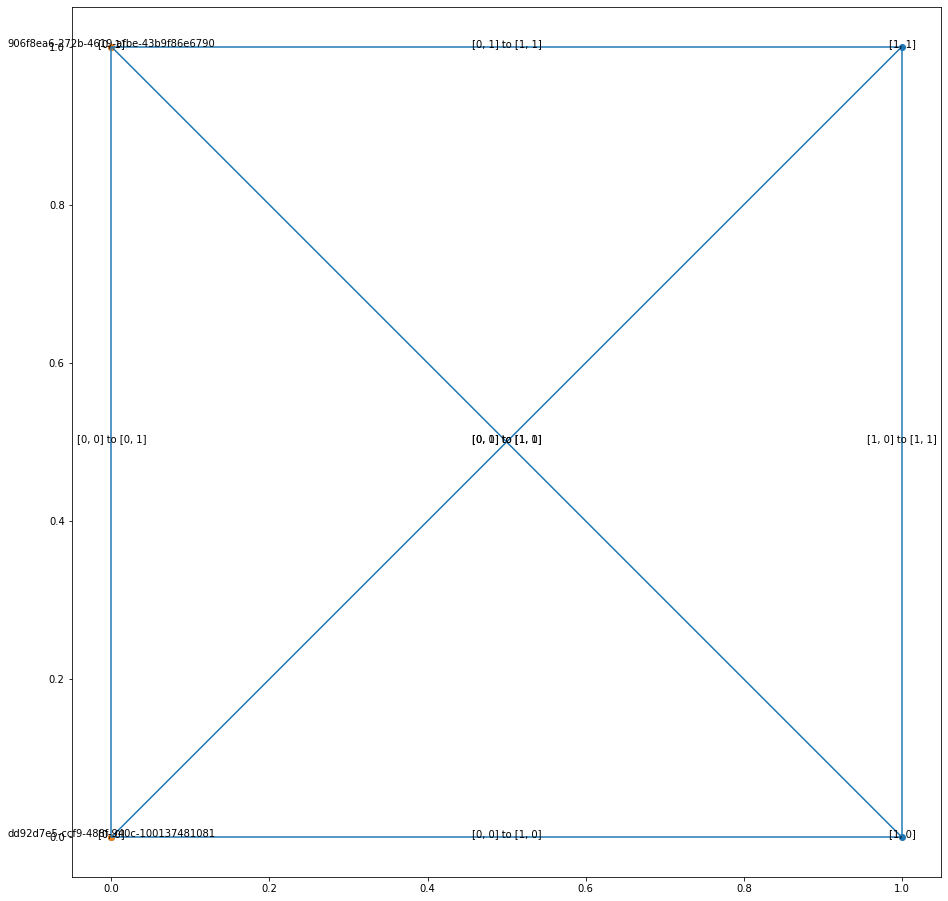

In [5]:
from pyproj import CRS

from dpd.modeling import Driver

model = TransportationModel()
abtmmap = ABTMMap(model, map_)

p1 = Driver(model, Point(0,0), [
    abtmmap.roads.loc["[0, 1] to [1, 1]"]["Road"],
    abtmmap.roads.loc["[0, 0] to [0, 1]"]["Road"]
])
p2 = Driver(model, Point(0,1), [
    abtmmap.roads.loc["[1, 0] to [1, 1]"]["Road"],
    abtmmap.roads.loc["[0, 1] to [1, 0]"]["Road"]
])
for person in [p1, p2]:
    abtmmap.add_person(person)

aea = CRS.from_string("North America Albers Equal Area Conic")
abtmmap.intersections.crs = aea
abtmmap.roads.crs = aea
abtmmap.people.crs = aea
trajectories = abtmmap.simulate(1, post_people=False)

abtmmap.plot(include_roads=True, include_intersections=True)

In [6]:
region = widgets.Select(
    options=list(
        map(
            lambda x: x.replace("_", " ").title().replace("Of", "of"),
            sources.available["subregions"]["usa"],
        )
    ),
    description="Region",
    rows=10,
    value="District of Columbia"
)
display(region)

Select(description='Region', index=7, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connec…

In [7]:
osmmap = OSMMap(region.value)

INFO:root:Building intersections...
100%|██████████| 51941/51941 [00:00<00:00, 91156.71it/s]
INFO:root:Building roads...
100%|██████████| 37831/37831 [30:46<00:00, 20.49it/s]  
INFO:root:Generated 51941 intersections and 155803 roads.


This is what was done in peopleModel.py

In [9]:
import us
YEAR = "2017"

zones = Zones.from_uscensus(str(us.states.lookup(region.value).fips), YEAR)
od = OriginDestinationDataFrame(
    OriginDestinationDataFrame.from_lodes(
        us.states.lookup(region.value).abbr.lower(), YEAR
    ).sample(100)
)

Exception ignored in: <function tqdm.__del__ at 0x12f4dff70>
Traceback (most recent call last):
  File "/Users/dbawssec/Library/Python/3.9/lib/python/site-packages/tqdm/std.py", line 1144, in __del__
    def __del__(self):
KeyboardInterrupt: 


This is what was done in routeModel.py

In [ ]:
osrm = OSRM(
    region="north-america/us/"
    + us.states.lookup(region.value).name.lower().replace(" ", "-"),
    profile_directory="/usr/local/Cellar/osrm-backend/5.24.0/share/osrm/profiles/",
    profile="car",
)
p = osrm.routed()
from time import sleep

sleep(1)
od.add_geometry_from_zones(zones)
od.add_route_hw_from_osrm(url_base="http://localhost:5000", mode="driving")
p.kill()

In [ ]:
model = TransportationModel()
abtmosmmap = ABTMMap(model, osmmap)
abtmosmmap.create_people_from_od(od.head(10))

This is what was done in simulation.py

In [ ]:
trajectories = abtmosmmap.simulate()

This is what was done in view.py

In [ ]:
#trajectories.add_speed()
trajectories.hvplot(line_width=10)

In [ ]:
import random

def random_color():
    return "#" + hex(random.randint(0, 0xFF))[2:] + hex(random.randint(0, 0xFF))[2:] + hex(random.randint(0, 0xFF))[2:]

features = []
for trajectory in trajectories.trajectories:
    color = random_color()
    df = trajectory.df.copy()
    df["previous_geometry"] = df["geometry"].shift()
    df["time"] = df.index
    df["previous_time"] = df["time"].shift()
    for _, row in df.iloc[1:].iterrows():
        coordinates = [
            [
                row["previous_geometry"].xy[0][0],
                row["previous_geometry"].xy[1][0]
            ],
            [
                row["geometry"].xy[0][0],
                row["geometry"].xy[1][0]
            ]
        ]
        times = [row["previous_time"].isoformat(), row["time"].isoformat()]
        features.append(
            {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": coordinates,
                },
                "properties": {
                    "times": times,
                    "style": {
                        "color": color,
                        "weight": 5,
                    },
                },
            }
        )

import folium
from folium.plugins import TimestampedGeoJson

m = folium.Map(location=[38.913340600000055, -77.009092], zoom_start=16)

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="PT1S",
    add_last_point=True,
    transition_time=1000
).add_to(m)

m